# HW3 DATASCI W261: Machine Learning at Scale 

* **Name:**  Megan Jasek
* **Email:**  meganjasek@ischool.berkeley.edu
* **Class Name:**  W261-2
* **Week Number:**  3
* **Date:**  5/31/16

**HW3.0.**  

**HW3.0A**How do you merge two sorted lists/arrays of records of the form [key, value]? Where is this used in Hadoop MapReduce? [Hint within the shuffle].  
ANSWER:  

Sorted lists are merged using 3 pointers.  
1. at the start of 1st sorted list
2. at the start of 2nd sorted list
3. at the start of the merged list.
The algorithm keeps picking off the smallest element from the beginning of the lists and adding it to the merged list until both of the original lists are empty.  Here is the algorithm:

def mergeSortedLists(a, b):  
L = []  
while a and b:  
if a[0] < b[0]:  
L.append(a.pop(0))  
else:  
L.append(b.pop(0))  
return L + a + b  

Hadoop uses this algorithm when merging lists of sorted keys during the Hadoop shuffle that happens after the mappers are finished but before the reducers start.

**HW3.0B** What is  a combiner function in the context of Hadoop?  Give an example where it can be used and justify why it should be used in the context of this problem.  
ANSWER:  
A combiner function is a function that aggregates outputs with the same key.  Combiners can be used on the output of a mapper function.  They can combine the output from the same key.  This is done to reduce network traffic from the mapper nodes to the reducer nodes.  This can save time in the mapreduce framework.

**HW3.0C** What is the Hadoop shuffle?  
ANSWER:  
The Hadoop shuffle is the process by which the mapreduce framework performs the sort and transfers the map outputs to the reducers as inputs.  The Hadoop shuffle can be summarized as follows:  
* On mapper node:  1) Partition the mapper output by key, so that every key is assigned a reducer node, 2) Sort the data by key, 3) Combine (aggregate) the data by key.
* On mapper node:  mergesort (repeat while output)
* Transmit data to reducer node
* On reducer node:  Combine (aggregate) the data by key.
* On reducer node:  mergesort partition files
* On reducer node:  send output to reducer function

**HW3.1** Consumer complaints dataset: Use Counters to do EDA (exploratory data analysis and to monitor progress.  
Now, let’s use Hadoop Counters to identify the number of complaints pertaining to debt collection, mortgage and other categories (all other categories get lumped into this one) in the consumer complaints dataset. Basically produce the distribution of the Product column in this dataset using counters (limited to 3 counters here).

Hadoop offers Job Tracker, an UI tool to determine the status and statistics of all jobs. Using the job tracker UI, developers can view the Counters that have been created. Screenshot your  job tracker UI as your job completes and include it here. Make sure that your user defined counters are visible.  

ANSWER: The counts from the EDA Counters are displayed in the table below as well as in the screenshot from the job tracker UI below.

| EDA Counter | Count |
| - | - |
| Debt Collection | 44,372 |
| Mortgage | 125,752 |
| Other Categories | 142,788 |


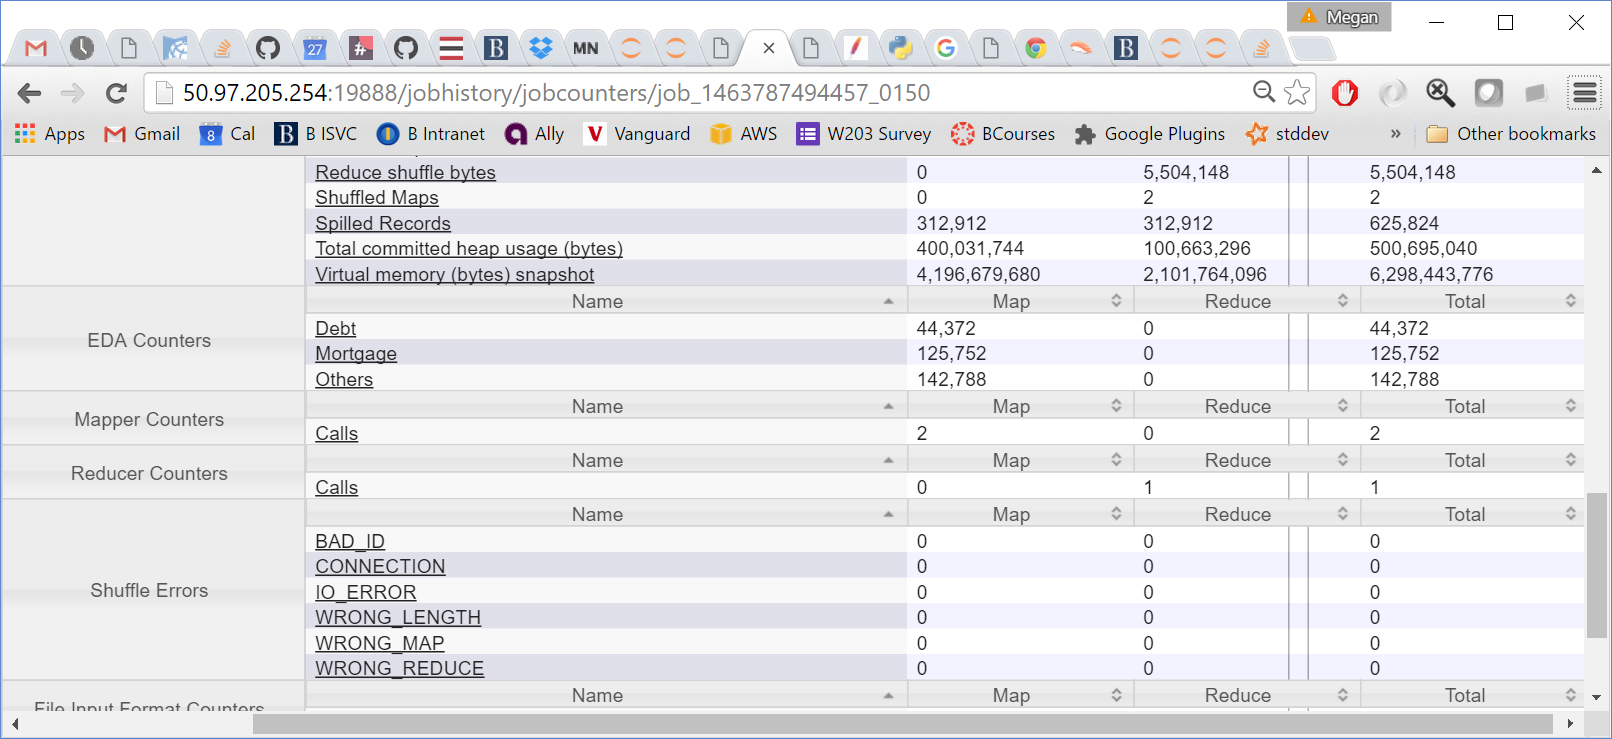

In [21]:
# Display the screen shot from job tracker showing the EDA counters
from IPython.display import Image
Image(filename="JobTrackerScreenShot.png")

In [1]:
# Set the location of the Hadoop Streaming jar
hadoopStreamingJar =  '/usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar'

In [23]:
# Read the Consumer_Complaints.csv input file into HDFS
!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal Consumer_Complaints.csv /user/hadoop
!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal Consumer_Complaints_small.csv /user/hadoop

In [3]:
# List out what is in the /user/hadoop directory in HDFS
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop

In [4]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.1
## The function takes the Consumer Complaints file as input and reads the Product column and
## counts the different types of products.  The categories are:  'debt collection', 'mortgage' and 'others'

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line on commas and store the product column value in the 'product' variable
    items = line.split(',')
    product = items[1].lower()
    # Skip the column header
    if product == "product":
        continue
    elif product == "debt collection":
        # Create a counter in the EDA Counters group called Debt that counts the products
        # in the debt collection group
        sys.stderr.write("reporter:counter:EDA Counters,Debt,1\n")
    elif product == "mortgage":
        # Create a counter in the EDA Counters group called Mortgage that counts the products
        # in the debt collection group
        sys.stderr.write("reporter:counter:EDA Counters,Mortgage,1\n")
    else:
        # Create a counter in the EDA Counters group called Others that counts the products
        # in all other groups
        sys.stderr.write("reporter:counter:EDA Counters,Others,1\n")
    # Print the product with a count of 1
    print('%s\t%d' % (product, 1))

Overwriting mapper.py


In [5]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.1
## This function expects keys to come in sorted.  It sums the values of all keys that are the same,
## then it outputs each key with its total sum of all of its values.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

cur_key = None
cur_count = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = items[1]
    # If this key is the same as the previous key add the value to the count
    if key == cur_key:
        cur_count += int(value)
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            print '%s\t%s' % (cur_key, cur_count)
        cur_key = key
        cur_count = int(value)

print '%s\t%s' % (cur_key, cur_count)

Overwriting reducer.py


In [8]:
##### HW3.1 ######
# Run a Hadoop Streaming job to do EDA with Counters
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-1/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-1
# Run a Hadoop streaming job.  The input file 'Consumer_Complaints.csv' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/Consumer_Complaints.csv -output /user/hadoop/outputHW3-1

16/06/04 11:29:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:29:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-1/_SUCCESS
16/06/04 11:29:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-1/part-00000
16/06/04 11:29:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:29:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5776475775276123673/] [] /tmp/streamjob6008090230147856448.jar tmpDir=null
16/06/04 11:29:52 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.205

In [9]:
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW3-1
# Print the output file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-1/part-00000

16/06/04 11:30:19 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 11:30 /user/hadoop/outputHW3-1/_SUCCESS
-rw-r--r--   3 hadoop supergroup        184 2016-06-04 11:30 /user/hadoop/outputHW3-1/part-00000
16/06/04 11:30:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
bank account or service	38073
consumer loan	9387
credit card	41563
credit reporting	41214
debt collection	44372
money transfers	1540
mortgage	125752
payday loan	1579
student loan	9432


**HW 3.2** Analyze the performance of your Mappers, Combiners and Reducers using Counters.

**HW 3.2A** For this brief study the Input file will be one record (the next line only):  
foo foo quux labs foo bar quux

Perform a word count analysis of this single record dataset using a Mapper and Reducer based WordCount (i.e., no combiners are used here) using user defined Counters to count up how many time the mapper and reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing this word count job. The answer should be 1 and 4 respectively. Please explain.

ANSWER:  The value of the Mapper counter was 2 and the value of the Reducer counter was 1.  Since there is only one line in the input file, the framework should just assign 1 mapper, but 2 were assigned.  This could be because the framework was going to run 2 jobs in parallel and see which one finished first and use the output from that one.  The framework chose 2 reducers for this job.  In order to have it use 4 reducers, the user could specify the number of reducers on the command line using the option '-D mapred.reduce.tasks=4'.

Please use mulitple mappers and reducers for these jobs (at least 2 mappers and 2 reducers).

**HW 3.2B** Perform a word count analysis of the Issue column of the Consumer Complaints  Dataset using a Mapper and Reducer based WordCount (i.e., no combiners used anywhere) using user defined Counters to count up how many time the mapper and reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing your word count job.  
ANSWER:  Using 2 mappers and 2 reducers and NO combiner.  See hadoop output below marked 'OUTPUT FOR HW3.2B'.  Command used is as follows:  
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \  
-D mapreduce.job.maps=2 \  
-D mapred.reduce.tasks=2 \  
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \  
-input /user/hadoop/Consumer_Complaints.csv -output /user/hadoop/outputHW3-2b     

	Mapper Counters  
		Calls=2  
	Reducer Counters  
		Calls=2  

**HW 3.2C** Perform a word count analysis of the Issue column of the Consumer Complaints  Dataset using a Mapper, Reducer, and standalone combiner (i.e., not an in-memory combiner) based WordCount using user defined Counters to count up how many time the mapper, combiner, reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing your word count job.  

ANSWER:  Using 2 mappers and 2 reducers and specifying a combiner.  See hadoop output below marked 'OUTPUT FOR HW3.2C'.  Command used is as follows:  
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \  
-D mapreduce.job.maps=2 \  
-D mapred.reduce.tasks=2 \  
-files mapper.py,reducer.py,combiner.py -mapper mapper.py -reducer reducer.py -combiner combiner.py \  
-input /user/hadoop/Consumer_Complaints.csv -output /user/hadoop/outputHW3-2c  

	Combiner Counters
		Calls=4
	Mapper Counters
		Calls=2
	Reducer Counters
		Calls=2

The combiners are called on the data 4 times.  This happens after the data is output from the mapper, but before it is input to the reducer.

**HW 3.2D** Using a single reducer: What are the top 50 most frequent terms in your word count analysis? Present the top 50 terms and their frequency and their relative frequency.  If there are ties please sort the tokens in alphanumeric/string order. Present bottom 10 tokens (least frequent items).  
ANSWER:  See hadoop output below marked 'OUTPUT FOR HW3.2D'.  Here are the top 10 values and the bottom 10 values:  

TOP 10 VALUES:  

| Term | Count | Relative Frequency |
| - | - | - |
| "loan | 107254 | 0.109596 |
| modification | 70487 | 0.072026 |
| credit | 50894 | 0.052005 |
| servicing | 36767 | 0.037570 |
| report | 30546 | 0.031213 |
| incorrect | 29069 | 0.029704 |
| information | 29069 | 0.029704 |
| on | 29069 | 0.029704 |
| or | 22533 | 0.023025 |
| debt | 19309 | 0.019731 |

BOTTOM 10 VALUES:  

| Term | Count | Relative Frequency |
| - | - | - |
| apply | 118 | 0.000121 |
| amount | 98 | 0.000100 |
| credited | 92 | 0.000094 |
| payment | 92 | 0.000094 |
| checks | 75 | 0.000077 |
| convenience | 75 | 0.000077 |
| amt | 71 | 0.000073 |
| day | 71 | 0.000073 |
| disclosures | 64 | 0.000065 |
| incorrect/missing | 64 | 0.000065 |


In [15]:
# Read the required input file into HDFS
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/hw3-2_strings.txt
!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal hw3-2_strings.txt /user/hadoop

16/05/27 13:35:37 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/27 13:35:37 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/hw3-2_strings.txt
16/05/27 13:35:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [16]:
# List out what is in the /user/hadoop directory in HDFS
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/hw3-2_strings.txt

16/05/27 13:35:42 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
foo foo quux labs foo bar quux


In [2]:
%%writefile wordcount_mapper.py
#!/usr/bin/env python
## wordcount_mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.2A

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

# input comes from STDIN (standard input)
# Break up each line by space delimiter and print each word with a count of 1.
for line in sys.stdin:
    for word in line.split():
        print('%s\t%d' % (word, 1))

Overwriting wordcount_mapper.py


In [3]:
%%writefile wordcount_reducer.py
#!/usr/bin/env python
## wordcount_reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.2A
## This function expects keys to come in sorted.  It sums the values of all keys that are the same,
## then it outputs each key with its total sum of all of its values.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

cur_key = None
cur_count = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = items[1]
    # If this key is the same as the previous key add the value to the count
    if key == cur_key:
        cur_count += int(value)
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            print '%s\t%s' % (cur_key, cur_count)
        cur_key = key
        cur_count = int(value)

print '%s\t%s' % (cur_key, cur_count)

Overwriting wordcount_reducer.py


In [4]:
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-2a/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-2a
# This job counts the words in the hw3-2_strings.txt file
# Run a Hadoop streaming job.  The input file 'hw3-2_strings.txt' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files wordcount_mapper.py,wordcount_reducer.py -mapper wordcount_mapper.py -reducer wordcount_reducer.py \
-input /user/hadoop/hw3-2_strings.txt -output /user/hadoop/outputHW3-2a

16/06/04 11:35:08 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:35:08 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2a/_SUCCESS
16/06/04 11:35:08 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2a/part-00000
16/06/04 11:35:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:35:10 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar2040064154600956250/] [] /tmp/streamjob4626979849676077103.jar tmpDir=null
16/06/04 11:35:11 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [5]:
########### Output for HW3.2A ############
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW3-2a
# Print the output file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2a/part-00000

16/06/04 11:35:35 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 11:35 /user/hadoop/outputHW3-2a/_SUCCESS
-rw-r--r--   3 hadoop supergroup         26 2016-06-04 11:35 /user/hadoop/outputHW3-2a/part-00000
16/06/04 11:35:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
bar	1
foo	3
labs	1
quux	2


In [6]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.2B, HW3.2C

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

# input comes from STDIN (standard input)
for line in sys.stdin:
    items = line.split(',')
    issue = items[3].lower()
    # If this is the column header, then do not count it.
    if issue == "issue":
        continue
    for word in issue.split():
        print('%s\t%d' % (word, 1))

Overwriting mapper.py


In [7]:
%%writefile combiner.py
#!/usr/bin/env python
## combiner.py
## Author: Megan Jasek
## Description: combiner code for HW3.2C
## This function expects keys to come in sorted.  It sums the values of all keys that are the same,
## then it outputs each key with its total sum of all of its values.

import sys

# Create a counter called Combiner Counters that will count the calls to function
sys.stderr.write("reporter:counter:Combiner Counters,Calls,1\n")

cur_key = None
cur_count = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = items[1]
    # If this key is the same as the previous key add the value to the count
    if key == cur_key:
        cur_count += int(value)
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            print '%s\t%s' % (cur_key, cur_count)
        cur_key = key
        cur_count = int(value)

print '%s\t%s' % (cur_key, cur_count)

Overwriting combiner.py


In [22]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.2B, HW3.2C
## This function expects keys to come in sorted.  It sums the values of all keys that are the same,
## then it outputs each key with its total sum of all of its values.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

cur_key = None
cur_count = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = items[1]
    # If this key is the same as the previous key add the value to the count
    if key == cur_key:
        cur_count += int(value)
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            print '%s\t%s' % (cur_key, cur_count)
        cur_key = key
        cur_count = int(value)

print '%s\t%s' % (cur_key, cur_count)

Overwriting reducer.py


In [8]:
#################### OUTPUT FOR HW3.2B ########################
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-2b/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-2b
# This job counts the words in the Issue column of the 'Consumer_Complaints.csv' file with no combiner
# Run a Hadoop streaming job.  The input file 'Consumer_Complaints.csv' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D mapreduce.job.maps=2 \
-D mapred.reduce.tasks=2 \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/Consumer_Complaints.csv -output /user/hadoop/outputHW3-2b

16/06/04 11:36:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:36:05 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2b/_SUCCESS
16/06/04 11:36:05 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2b/part-00000
16/06/04 11:36:05 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2b/part-00001
16/06/04 11:36:06 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:36:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJa

In [9]:
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW3-2b
# Print the output file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2b/part-00000
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2b/part-00001

16/06/04 11:36:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 11:36 /user/hadoop/outputHW3-2b/_SUCCESS
-rw-r--r--   3 hadoop supergroup        964 2016-06-04 11:36 /user/hadoop/outputHW3-2b/part-00000
-rw-r--r--   3 hadoop supergroup       1205 2016-06-04 11:36 /user/hadoop/outputHW3-2b/part-00001
16/06/04 11:36:39 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"account	16205
/	12386
a	3503
account	4476
acct	163
an	2505
and	16448
applied	139
apr	3431
arbitration	168
available	274
bankruptcy	222
being	5663
billing	8158
by	5663
can't	1999
cash	240
caused	5663
changes	350
charges	131
checks	75
company's	4858
cont'd	11848
convenience	75
credit	50894
debt	19309
delay	243
delinquent	1061
deposits	10555
determination	1490
disclosure	5214
disputes	6938
expect	

In [10]:
#################### OUTPUT FOR HW3.2C ########################
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-2c/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-2c
# This job counts the words in the Issue column of the 'Consumer_Complaints.csv' file with a combiner
# Run a Hadoop streaming job.  The input file 'Consumer_Complaints.csv' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D mapreduce.job.maps=2 \
-D mapred.reduce.tasks=2 \
-files mapper.py,reducer.py,combiner.py -mapper mapper.py -reducer reducer.py -combiner combiner.py \
-input /user/hadoop/Consumer_Complaints.csv -output /user/hadoop/outputHW3-2c

16/06/04 11:37:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:37:01 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2c/_SUCCESS
16/06/04 11:37:01 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2c/part-00000
16/06/04 11:37:01 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2c/part-00001
16/06/04 11:37:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:37:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJa

In [11]:
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW3-2c
# Print the output file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2c/part-00000
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2c/part-00001

16/06/04 11:38:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 11:37 /user/hadoop/outputHW3-2c/_SUCCESS
-rw-r--r--   3 hadoop supergroup        964 2016-06-04 11:37 /user/hadoop/outputHW3-2c/part-00000
-rw-r--r--   3 hadoop supergroup       1205 2016-06-04 11:37 /user/hadoop/outputHW3-2c/part-00001
16/06/04 11:38:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"account	16205
/	12386
a	3503
account	4476
acct	163
an	2505
and	16448
applied	139
apr	3431
arbitration	168
available	274
bankruptcy	222
being	5663
billing	8158
by	5663
can't	1999
cash	240
caused	5663
changes	350
charges	131
checks	75
company's	4858
cont'd	11848
convenience	75
credit	50894
debt	19309
delay	243
delinquent	1061
deposits	10555
determination	1490
disclosure	5214
disputes	6938
expect	

In [9]:
# Copy the output of the Issues Column Word Count to separate files to use as input for sorting
!/usr/local/hadoop/bin/hdfs dfs -cp /user/hadoop/outputHW3-2c/part-00000 /user/hadoop/cc_wordcount_1
!/usr/local/hadoop/bin/hdfs dfs -cp /user/hadoop/outputHW3-2c/part-00001 /user/hadoop/cc_wordcount_2

16/05/27 18:05:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/27 18:05:04 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [12]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.2D
## This function passes the words and counts to the reducer.  It also sums up two other values:
## total word count (count_words) and total unique word count (count_unique).  And passes those
## values on to the reducer using special marker values 1000000000 and 2000000000.  This
## technique is called order inversion.

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

count_words = 0
count_unique = 0

# input comes from STDIN (standard input)
# Sum up the total word count and total word count of unique words
# Print each word and its count for the reducer
for line in sys.stdin:
    # Split the line on tabs
    word, value = line.split('\t')
    count_words += int(value)
    count_unique += 1
    print('%s\t%d' % (word, int(value)))

# Print the special values 1000000000 and 2000000000 to mark the total count of words
# and the total unique count of words
print('%d\t1000000000' % (count_words))
print('%d\t2000000000' % (count_unique))

Overwriting mapper.py


In [13]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.2D
## This function expects keys to come in sorted.  Special values from the mapper, values 1000000000
## and 2000000000 are used here to mark any total word count counts or unique word count counts.
## Because these values are so high, they will come in first from the mappers, so the total word
## count and total unique word count can be calculated first and then used for other calculations
## in the function.  The reducer can quickly calculate the relative frequency of a word
## by dividing by the total word count.  The top most frequent words are printed and the 10 least
## frequent words are printed.  The reducer uses the total unique word count to understand which
## words will be the 10 last in the sorted list.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

count_words = 0
count_unique = 0
i = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = int(items[1])
    # If the value equals the special number 1000000000, this indicates this is a total 
    # word count value and it should be added to the count_words total
    if value == 1000000000:
        count_words += float(key)
    # If the value equals the special number 2000000000, this indicates this is a unique 
    # word count value and it should be added to the count_unique total
    elif value == 2000000000:
        count_unique += float(key)
    else:
        # Print only the 50 most frequent and the 10 least frequent words
        if (i < 50) or (i >= (count_unique-10)):
            print('%s\t%s\t%f' % (key, value, value/count_words))
        i += 1

Overwriting reducer.py


In [14]:
##### 3.2D #############
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-2d/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-2d
# This job sorts the word counts from the Issue column of the 'Consumer_Complaints.csv' file
# Run a Hadoop streaming job.  The input file '/user/hadoop/cc_wordcount_1' and 
# '/user/hadoop/cc_wordcount_2' are passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D stream.num.map.output.key.field=2 \
-D stream.map.output.field.separator="\t" \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options="-k2,2nr -k1,1" \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/cc_wordcount_1,/user/hadoop/cc_wordcount_2 -output /user/hadoop/outputHW3-2d

16/06/04 11:38:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:38:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2d/_SUCCESS
16/06/04 11:38:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2d/part-00000
16/06/04 11:38:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:38:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar7337312560870494984/] [] /tmp/streamjob4285383873923131888.jar tmpDir=null
16/06/04 11:38:50 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [15]:
#################### OUTPUT FOR HW3.2D ########################
# Print the output file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2d/part-00000

16/06/04 11:39:13 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"loan	107254	0.109596
modification	70487	0.072026
credit	50894	0.052005
servicing	36767	0.037570
report	30546	0.031213
incorrect	29069	0.029704
information	29069	0.029704
on	29069	0.029704
or	22533	0.023025
debt	19309	0.019731
and	16448	0.016807
"account	16205	0.016559
opening	16205	0.016559
club	12545	0.012819
health	12545	0.012819
/	12386	0.012656
not	12353	0.012623
loan	12237	0.012504
attempts	11848	0.012107
collect	11848	0.012107
cont'd	11848	0.012107
owed	11848	0.012107
of	10885	0.011123
my	10731	0.010965
deposits	10555	0.010785
withdrawals	10555	0.010785
problems	9484	0.009691
"application	8625	0.008813
to	8401	0.008584
unable	8178	0.008357
billing	8158	0.008336
other	7886	0.008058
disputes	6938	0.007089
communication	6920	0.007071
tactics	6920	0.007071
reporting	6559	0.006702
lease	6337	0.006475
the	6248	0.006384
being	5663	0.005787


**HW3.2.1**  Using 2 reducers: What are the top 50 most frequent terms in your word count analysis? Present the top 50 terms and their frequency and their relative frequency. If there are ties please sort the tokens in alphanumeric/string order. Present bottom 10 tokens (least frequent items). Please use a combiner.  
ANSWER: See hadoop output below marked 'OUTPUT FOR HW3.2.1'. Here are the top 10 values and the bottom 10 values:

TOP 10 VALUES:  

| Term | Count | Relative Frequency |
| - | - | - |
| "loan | 107254 | 0.109596 |
| modification | 70487 | 0.072026 |
| credit | 50894 | 0.052005 |
| servicing | 36767 | 0.037570 |
| report | 30546 | 0.031213 |
| incorrect | 29069 | 0.029704 |
| information | 29069 | 0.029704 |
| on | 29069 | 0.029704 |
| or | 22533 | 0.023025 |
| debt | 19309 | 0.019731 |

BOTTOM 10 VALUES:  

| Term | Count | Relative Frequency |
| - | - | - |
| apply | 118 | 0.000121 |
| amount | 98 | 0.000100 |
| credited | 92 | 0.000094 |
| payment | 92 | 0.000094 |
| checks | 75 | 0.000077 |
| convenience | 75 | 0.000077 |
| amt | 71 | 0.000073 |
| day | 71 | 0.000073 |
| disclosures | 64 | 0.000065 |
| incorrect/missing | 64 | 0.000065 |


In [16]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.2.1
## This function passes the words and counts to the reducer.  It also sums up the
## total word count (count_words).  And passes it on to the reducer using special marker
## value 1000000000.  This technique is called order inversion.

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

count_words = 0

# input comes from STDIN (standard input)
# Sum up the total word count and total word count of unique words
# Print each word and its count for the reducer
for line in sys.stdin:
    # Split the line on tabs
    word, value = line.split('\t')
    if int(value) < 3000:
        label = "a"
    else:
        label = "b"
    count_words += int(value)
    print('%s\t%s\t%d' % (label, word, int(value)))

# Print the special value 1000000000 to mark the total count of words
print('a\t%d\t1000000000' % (count_words))
print('b\t%d\t1000000000' % (count_words))

Overwriting mapper.py


In [17]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.2.1
## This function expects keys to come in sorted.  Special values from the mapper, value 1000000000
## is used here to mark any total word count counts.
## Because this values is so high, it will come in first from the mappers, so the total word
## count and total unique word count can be calculated first and then used for other calculations
## in the function.  The reducer can quickly calculate the relative frequency of a word
## by dividing by the total word count.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

count_words = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd and 3rd items as label and key and value
    label = items[0]
    key = items[1]
    value = int(items[2])
    # If the value equals the special number 1000000000, this indicates this is a total 
    # word count value and it should be added to the count_words total
    if value == 1000000000:
        count_words += float(key)
    else:
        print('%s\t%s\t%f' % (key, value, value/count_words))

Overwriting reducer.py


In [18]:
#### 3.2.1 #####
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-2-1/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-2-1
# This job sorts the word counts from the Issue column of the 'Consumer_Complaints.csv' file
# Run a Hadoop streaming job.  The input file '/user/hadoop/cc_wordcount_1' and 
# '/user/hadoop/cc_wordcount_2' are passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D stream.num.map.output.key.field=3 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options="-k3,3nr -k2,2" \
-D mapred.reduce.tasks=2 \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/cc_wordcount_1,/user/hadoop/cc_wordcount_2 -output /user/hadoop/outputHW3-2-1 \
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner

16/06/04 11:40:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:40:54 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2-1/_SUCCESS
16/06/04 11:40:54 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2-1/part-00000
16/06/04 11:40:54 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-2-1/part-00001
16/06/04 11:40:55 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 11:40:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJo

In [34]:
#################### OUTPUT FOR HW3.2.1 ########################
print('TOP 50 WORDS')
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2-1/part-00000 | head -50
print('BOTTOM 10 WORDS')
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-2-1/part-00001 | tail -10

TOP 50 WORDS
16/06/04 12:07:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"loan	107254	0.109596
modification	70487	0.072026
credit	50894	0.052005
servicing	36767	0.037570
report	30546	0.031213
incorrect	29069	0.029704
information	29069	0.029704
on	29069	0.029704
or	22533	0.023025
debt	19309	0.019731
and	16448	0.016807
"account	16205	0.016559
opening	16205	0.016559
club	12545	0.012819
health	12545	0.012819
/	12386	0.012656
not	12353	0.012623
loan	12237	0.012504
attempts	11848	0.012107
collect	11848	0.012107
cont'd	11848	0.012107
owed	11848	0.012107
of	10885	0.011123
my	10731	0.010965
deposits	10555	0.010785
withdrawals	10555	0.010785
problems	9484	0.009691
"application	8625	0.008813
to	8401	0.008584
unable	8178	0.008357
billing	8158	0.008336
other	7886	0.008058
disputes	6938	0.007089
communication	6920	0.007071
tactics	6920	0.007071
reporting	6559	0.006702
lease	6337	0.006475
the	6248	0.006384
being	5

**HW3.3.** Shopping Cart Analysis.  Do some exploratory data analysis of this dataset guided by the following questions:. 

How many unique items are available from this supplier?

Using a single reducer: Report your findings such as number of unique products; largest basket; report the top 50 most frequently purchased items,  their frequency,  and their relative frequency (break ties by sorting the products alphabetical order) etc. using Hadoop Map-Reduce.  

ANSWER:  See hadoop output labeled 'OUTPUT FOR HW3.3'

Number of Unique Products: 12592  
Largest Basket: 37	

| Product ID | Frequency | Relative frequency |  
| - | - | - |  
| DAI62779 | 6667 | 0.017507 |  
| FRO40251 | 3881 | 0.010191 |  
| ELE17451 | 3875 | 0.010175 |  
| GRO73461 | 3602 | 0.009458 |  
| SNA80324 | 3044 | 0.007993 |  
| ELE32164 | 2851 | 0.007486 |  
| DAI75645 | 2736 | 0.007184 |  
| SNA45677 | 2455 | 0.006447 |  
| FRO31317 | 2330 | 0.006118 |  
| DAI85309 | 2293 | 0.006021 |  

...for the remaining products: See hadoop output labeled 'OUTPUT FOR HW3.3' below>  

In [94]:
# Read the ProductPurchaseData.txt input file into HDFS
!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal ProductPurchaseData.txt /user/hadoop
!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal ProductPurchaseData_small.txt /user/hadoop
#!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop

16/05/28 20:18:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 32 items
-rw-r--r--   3 hadoop supergroup   50906486 2016-05-26 23:08 /user/hadoop/Consumer_Complaints.csv
-rw-r--r--   3 hadoop supergroup      16478 2016-05-27 00:04 /user/hadoop/Consumer_Complaints_small.csv
-rw-r--r--   3 hadoop supergroup    3458517 2016-05-28 17:14 /user/hadoop/ProductPurchaseData.txt
-rw-r--r--   3 hadoop supergroup      10918 2016-05-28 20:17 /user/hadoop/ProductPurchaseData_small.txt
-rw-r--r--   3 hadoop supergroup        964 2016-05-27 18:04 /user/hadoop/cc_wordcount_1
-rw-r--r--   3 hadoop supergroup       1205 2016-05-27 18:05 /user/hadoop/cc_wordcount_2
-rw-r--r--   3 hadoop supergroup     203981 2016-05-21 14:24 /user/hadoop/enronemail_1h.txt
-rw-r--r--   3 hadoop supergroup         31 2016-05-27 13:35 /user/hadoop/hw3-2_strings.txt
drwxr-xr-x   - hadoop supergroup          0 2016-05-27 11:54 /user/hado

In [35]:
%%writefile max_mapper.py
#!/usr/bin/env python
## max_mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.3A
## Print the count of 1 for each unique product in the input file and print the
## largest basket size with a special marker: *largestbasket

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

largest_basket = 0

# input comes from STDIN (standard input)
# Break up each line by space delimiter and print each product with a count of 1.
# Keep track of the largest basket size and print it with a special marker:  *largestbasket
# so that it is passed to the reducer
for line in sys.stdin:
    basket_size = 0
    for product in line.split():
        basket_size += 1
        print('%s\t%d' % (product, 1))
    if basket_size > largest_basket:
        largest_basket = basket_size
print('*largestbasket\t%d' % (largest_basket))

Overwriting max_mapper.py


In [36]:
%%writefile max_reducer.py
#!/usr/bin/env python
## max_reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.3
## This function expects keys to come in sorted.  It sums the values of all keys that are the same,
## then it outputs each key with its total sum of all of its values.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

cur_key = None
cur_count = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = items[1]
    # If this key is the same as the previous key add the value to the count
    if key == cur_key:
        if key == "*largestbasket":
            cur_count = max(cur_count, int(value))
        else:
            cur_count += int(value)
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            print '%s\t%s' % (cur_key, cur_count)
        cur_key = key
        cur_count = int(value)

print '%s\t%s' % (cur_key, cur_count)

Overwriting max_reducer.py


In [37]:
# Step 1: Run a product count of the products in the ProductPurchaseData.txt file
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-3a/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-3a
# Run a Hadoop streaming job.  The input file 'ProductPurchaseData.txt' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files max_mapper.py,max_reducer.py -mapper max_mapper.py -reducer max_reducer.py \
-input /user/hadoop/ProductPurchaseData.txt -output /user/hadoop/outputHW3-3a

16/06/04 12:09:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:09:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-3a/_SUCCESS
16/06/04 12:09:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-3a/part-00000
16/06/04 12:09:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:09:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar8520440456665294864/] [] /tmp/streamjob590019367915300576.jar tmpDir=null
16/06/04 12:09:24 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.20

In [10]:
#################### HW3.3 PRODUCT WORD COUNTS ########################
# Print the output file
#!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-3a/part-00000
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/product_counts
!/usr/local/hadoop/bin/hdfs dfs -cp /user/hadoop/outputHW3-3a/part-00000 /user/hadoop/product_counts
!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/product_counts product_counts.txt

16/05/29 18:49:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/29 18:49:57 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/product_counts
16/05/29 18:49:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/29 18:49:59 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/05/29 18:50:00 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/29 18:50:00 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [38]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.3
## This function passes the products and counts to the reducer.  It also sums up the
## total product count (count_products) and total unique products (count_unique) and stores the 
## largest basket size.  It passes these values on to the reducer using special marker
## value 1000000000, 2000000000 and 3000000000.  This technique is called order inversion.

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

# Initialize the counts to 0
count_products = 0
largest_basket = 0
count_unique = 0

# input comes from STDIN (standard input)
# Sum up the total product count and total count of unique products
# and pass the largestbasket value through to the reducer
# Print each product and its count for the reducer
for line in sys.stdin:
    # Split the line on tabs
    product, count = line.split('\t')
    if product == "*largestbasket":
        largest_basket = int(count)
    else:
        count_products += int(count)
        count_unique += 1
        print('%s\t%d' % (product, int(count)))

# Print the special values 1000000000, 2000000000 and 3000000000 to mark the total counts
# and largest basket size
print('%d\t1000000000' % (count_products))
print('%d\t2000000000' % (largest_basket))
print('%d\t3000000000' % (count_unique))

Overwriting mapper.py


In [39]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.3
## This function expects keys to come in sorted.  Special values from the mapper, value 1000000000,
## 2000000000 and 3000000000 are used here to mark total product counts and the largest basket size.
## Because these values are so high, it will come in first from the mappers and used in the rest of 
## the function.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

# Initialize the counters
count_products = 0
largest_basket = 0
count_unique = 0
i = 0

READING_COUNTERS = True

for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd and items as key and value
    key = items[0]
    value = int(items[1])
    # If the value equals the special number 1000000000, this indicates this is a total 
    # product count value and it should be added to the count_products total
    if value == 1000000000:
        count_products += float(key)
    # If the value equals the special number 2000000000, this indicates this is a 
    # largest basket marker and the max of the current largest basket should be compared
    # to it and the max of those values set to the current largest basket
    elif value == 2000000000:
        largest_basket = max(largest_basket, int(key))
    # If the value equals the special number 3000000000, this indicates this is a total 
    # unique product count value and it should be added to the count_unique total
    elif value == 3000000000:
        count_unique += int(key)
    else:
        # If its done reading the counters, then print the counters as reducer output
        if READING_COUNTERS:
            print('# Unique Products: %d' % (count_unique))
            print('Largest Basket: %d' % (largest_basket))
            READING_COUNTERS = False
        # Only print the top 50 most frequent products
        if i < 50:
            print('%s\t%s\t%f' % (key, value, value/count_products))
        i += 1

Overwriting reducer.py


In [40]:
####################### HW3.3 ######################
# Run a job to find the number of unique products, the largest basket size and the to 50 most frequently bought products.
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-3b/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-3b
# Run a Hadoop streaming job.  The input file 'Consumer_Complaints.csv' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D stream.num.map.output.key.field=2 \
-D stream.map.output.field.separator="\t" \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options="-k2,2nr -k1,1" \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/product_counts -output /user/hadoop/outputHW3-3b

16/06/04 12:10:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:10:18 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-3b/_SUCCESS
16/06/04 12:10:18 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-3b/part-00000
16/06/04 12:10:18 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:10:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar7572470338387498323/] [] /tmp/streamjob8247200251963215114.jar tmpDir=null
16/06/04 12:10:20 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [41]:
#################### OUTPUT FOR HW3.3 ########################
# Print number of unique products, the largest basket size and the to 50 most frequently bought products.
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-3b/part-00000

16/06/04 12:11:08 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
# Unique Products: 12592	
Largest Basket: 37	
DAI62779	6667	0.017507
FRO40251	3881	0.010191
ELE17451	3875	0.010175
GRO73461	3602	0.009458
SNA80324	3044	0.007993
ELE32164	2851	0.007486
DAI75645	2736	0.007184
SNA45677	2455	0.006447
FRO31317	2330	0.006118
DAI85309	2293	0.006021
ELE26917	2292	0.006019
FRO80039	2233	0.005864
GRO21487	2115	0.005554
SNA99873	2083	0.005470
GRO59710	2004	0.005262
GRO71621	1920	0.005042
FRO85978	1918	0.005036
GRO30386	1840	0.004832
ELE74009	1816	0.004769
GRO56726	1784	0.004685
DAI63921	1773	0.004656
GRO46854	1756	0.004611
ELE66600	1713	0.004498
DAI83733	1712	0.004496
FRO32293	1702	0.004469
ELE66810	1697	0.004456
SNA55762	1646	0.004322
DAI22177	1627	0.004272
FRO78087	1531	0.004020
ELE99737	1516	0.003981
ELE34057	1489	0.003910
GRO94758	1489	0.003910
FRO35904	1436	0.003771
FRO53271	1420	0.003729
SNA93860	1407	0.003695
S

**HW3.4** (Computationally prohibitive but then again Hadoop can handle this) Pairs

Suppose we want to recommend new products to the customer based on the products they have already browsed on the online website. Write a map-reduce program to find products which are frequently browsed together. Fix the support count (cooccurence count) to s = 100 (i.e. product pairs need to occur together at least 100 times to be considered frequent) and find pairs of items (sometimes referred to itemsets of size 2 in association rule mining) that have a support count of 100 or more.

**HW3.4A**  List the top 50 product pairs with corresponding support count (aka frequency), and relative frequency or support (number of records where they coccur, the number of records where they coccur/the number of baskets in the dataset) in decreasing order of support  for frequent (100>count) itemsets of size 2.  Use the Pairs pattern (lecture 3) to extract these frequent itemsets of size 2. Free free to use combiners if they bring value.  Please output records of the following form for the top 50 pairs (itemsets of size 2):  

      item1, item2, support count, support  

Fix the ordering of the pairs lexicographically (left to right), and break ties in support (between pairs, if any exist) by taking the first ones in lexicographically increasing order.  

ANSWER:  See the Hadoop output marked 'OUTPUT FOR HW3.4'.  Below are the 10 most frequent pairs.  The full list of 50 pairs is in the output section marked 'OUTPUT FOR HW3.4' below.  

| Product 1 | Product 2 | Pair Frequency | Pair Relative frequency |  
| - | - | - | - |  
| DAI62779 | ELE17451 | 1592 | 0.051188 |  	
| FRO40251 | SNA80324 | 1412 | 0.045400 |  
| DAI75645 | FRO40251 | 1254 | 0.040320 |  
| FRO40251 | GRO85051 | 1213 | 0.039002 |  
| DAI62779 | GRO73461 | 1139 | 0.036623 |  
| DAI75645 | SNA80324 | 1130 | 0.036333 |  
| DAI62779 | FRO40251 | 1070 | 0.034404 |  
| DAI62779 | SNA80324 | 923 | 0.029678 |  
| DAI62779 | DAI85309 | 918 | 0.029517 |  
| ELE32164 | GRO59710 | 911 | 0.029292 |  

**HW3.4B**  Report  the compute time for the Pairs job. Describe the computational setup used (E.g., single computer; dual core; linux, number of mappers, number of reducers)  

Computational setup:  singler server, dual core, 4G RAM, Centos 7.0  

Times for Step 1 - Wordcount MR job:  
Mappers:  2, Reducers:  1  

		Total time spent by all map tasks (ms)=21,150  
		Total time spent by all reduce tasks (ms)=4,049  
        Total time spent by all tasks (ms)=25,199

Times for Step 2 - Sorting MR job:  
Mappers:  2, Reducers:  1  

		Total time spent by all map tasks (ms)=6,594
		Total time spent by all reduce tasks (ms)=1,908
        Total time spent by all tasks (ms)=8,502

**HW3.4C**  Instrument your mapper, combiner, and reducer to count how many times each is called using Counters and report these counts.  
Counters for Step 1 - Wordcount MR job:  

	Combiner Counters
		Calls=2
	Mapper Counters
		Calls=2
	Reducer Counters
		Calls=1

Counters for Step 2 - Sorting MR job:  

	Mapper Counters
		Identity Calls=2
	Reducer Counters
		Calls=1

In [42]:
%%writefile pair_mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.4A
## Print the count of 1 for each unique product pair in each basket in the input file and print the
## basket count with the special marker: (*basketcount,*basketcount)

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

count_basket = 0

# input comes from STDIN (standard input)
# Break up each line by space delimiter and print each product pair in each basket with a count of 1.
# Keep track of the basket count and print it with a special marker: (*basketcount,*basketcount)
# so that it is passed to the reducer
for line in sys.stdin:
    products = line.split()
    for i in range(len(products)-1):
        pi = products[i]
        for pj in products[i+1:]:
            if pi > pj:
                print('(%s,%s)\t%d' % (pj, pi, 1))
            else:
                print('(%s,%s)\t%d' % (pi, pj, 1))
    count_basket += 1

print('(*basketcount,*basketcount)\t%d' % (count_basket))

Overwriting pair_mapper.py


In [43]:
%%writefile pair_combiner.py
#!/usr/bin/env python
## pair_combiner.py
## Author: Megan Jasek
## Description: combiner code for HW3.4A
## This function expects keys to come in sorted.  It sums the values of all keys that are the same,
## then it outputs each key with its total sum of all of its values.

import sys

# Create a counter called Combiner Counters that will count the calls to function
sys.stderr.write("reporter:counter:Combiner Counters,Calls,1\n")

cur_key = None
cur_count = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = items[1]
    # If this key is the same as the previous key add the value to the count
    if key == cur_key:
        cur_count += int(value)
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            print '%s\t%s' % (cur_key, cur_count)
        cur_key = key
        cur_count = int(value)

print '%s\t%s' % (cur_key, cur_count)

Overwriting pair_combiner.py


In [44]:
%%writefile pair_reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.4A
## This function expects keys to come in sorted.  It sums the values of all keys that are the same,
## then it outputs each key with its total sum of all of its values.  It only outputs keys with
## values of at least 100.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

cur_key = None
cur_count = 0
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    value = items[1]
    # If this key is the same as the previous key add the value to the count
    if key == cur_key:
        cur_count += int(value)
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            if cur_count >= 100:
                print '%s\t%s' % (cur_key, cur_count)
        cur_key = key
        cur_count = int(value)

if cur_count >= 100:
    print '%s\t%s' % (cur_key, cur_count)

Overwriting pair_reducer.py


In [45]:
####### HW3.4
# Step 1: Run a count of the product pairs in each basket in the ProductPurchaseData.txt file
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-4a/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-4a
# Run a Hadoop streaming job.  The input file 'ProductPurchaseData.txt' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files pair_mapper.py,pair_reducer.py,pair_combiner.py -mapper pair_mapper.py -reducer pair_reducer.py -combiner pair_combiner.py \
-input /user/hadoop/ProductPurchaseData.txt -output /user/hadoop/outputHW3-4a

16/06/04 12:12:47 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:12:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-4a/_SUCCESS
16/06/04 12:12:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-4a/part-00000
16/06/04 12:12:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:12:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5559663364216954746/] [] /tmp/streamjob3101867790597820816.jar tmpDir=null
16/06/04 12:12:50 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [116]:
# Print the output from the file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-4a/part-00000
# This command takes a long time to run
#!/usr/local/hadoop/bin/hdfs dfs -cp /user/hadoop/outputHW3-4a/part-00000 /user/hadoop/product_pairs_output_full
# Save the output of the counts for Step 2
!/usr/local/hadoop/bin/hdfs dfs -cp /user/hadoop/outputHW3-4a/part-00000 /user/hadoop/product_pairs_output

16/05/28 20:49:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
(*basketcount,*basketcount)	31101
(DAI16732,FRO78087)	106
(DAI18527,SNA44451)	102
(DAI22177,DAI31081)	127
(DAI22177,DAI62779)	382
(DAI22177,DAI63921)	136
(DAI22177,DAI75645)	123
(DAI22177,DAI83733)	126
(DAI22177,DAI85309)	172
(DAI22177,ELE17451)	203
(DAI22177,ELE26917)	134
(DAI22177,ELE32164)	155
(DAI22177,ELE34057)	107
(DAI22177,ELE56788)	134
(DAI22177,ELE66600)	101
(DAI22177,ELE66810)	105
(DAI22177,ELE74009)	108
(DAI22177,ELE91337)	150
(DAI22177,FRO31317)	160
(DAI22177,FRO32293)	128
(DAI22177,FRO40251)	181
(DAI22177,FRO66272)	130
(DAI22177,FRO78087)	107
(DAI22177,FRO80039)	152
(DAI22177,FRO85978)	156
(DAI22177,GRO21487)	122
(DAI22177,GRO30386)	106
(DAI22177,GRO46854)	160
(DAI22177,GRO59710)	120
(DAI22177,GRO71621)	132
(DAI22177,GRO73461)	248
(DAI22177,SNA45677)	145
(DAI22177,SNA55762)	102
(DAI22177,SNA80324)	140
(DAI22177,SNA99873)	148
(D

In [46]:
%%writefile product_reducer.py
#!/usr/bin/env python
## product_reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.4
## This function expects keys to come in sorted.  The special value from the mapper: (*basketcount,*basketcount)
## is used here to mark total basket count.
## Because this value is so high, it will come in first from the mappers and used in the rest of 
## the function.

import sys

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

# Initialize the counters
count_basket = 0
i = 0

for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd and items as key and value
    key = items[0]
    value = int(items[1])
    # If the value equals the special number (*basketcount,*basketcount), this indicates this is a total 
    # basket count value and it should be added to the count_basket total
    if key == '(*basketcount,*basketcount)':
        count_basket += float(value)
    else:
        # Only print the top 50 most frequent product pairs
        if i < 50:
            key1, key2 = key.strip('()').split(',')
            print('%s, %s, %s, %f' % (key1, key2, value, value/count_basket))
        i += 1

Overwriting product_reducer.py


In [47]:
####################### HW3.4 ######################
# Step 2: Run the sorting job
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-4b/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-4b
# Run a Hadoop streaming job.  The input file 'Consumer_Complaints.csv' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D stream.num.map.output.key.field=2 \
-D stream.map.output.field.separator="\t" \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options="-k2,2nr -k1,1" \
-files Imapper.py,product_reducer.py -mapper Imapper.py -reducer product_reducer.py \
-input /user/hadoop/product_pairs_output -output /user/hadoop/outputHW3-4b

16/06/04 12:13:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:13:51 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-4b/_SUCCESS
16/06/04 12:13:51 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-4b/part-00000
16/06/04 12:13:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:13:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar1910620679379465661/] [] /tmp/streamjob2440371543377419725.jar tmpDir=null
16/06/04 12:13:54 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [48]:
################## OUTPUT FOR HW3.4 ######################
# Print the output from the file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-4b/part-00000

16/06/04 12:14:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
DAI62779, ELE17451, 1592, 0.051188	
FRO40251, SNA80324, 1412, 0.045400	
DAI75645, FRO40251, 1254, 0.040320	
FRO40251, GRO85051, 1213, 0.039002	
DAI62779, GRO73461, 1139, 0.036623	
DAI75645, SNA80324, 1130, 0.036333	
DAI62779, FRO40251, 1070, 0.034404	
DAI62779, SNA80324, 923, 0.029678	
DAI62779, DAI85309, 918, 0.029517	
ELE32164, GRO59710, 911, 0.029292	
DAI62779, DAI75645, 882, 0.028359	
FRO40251, GRO73461, 882, 0.028359	
DAI62779, ELE92920, 877, 0.028198	
FRO40251, FRO92469, 835, 0.026848	
DAI62779, ELE32164, 832, 0.026752	
DAI75645, GRO73461, 712, 0.022893	
DAI43223, ELE32164, 711, 0.022861	
DAI62779, GRO30386, 709, 0.022797	
ELE17451, FRO40251, 697, 0.022411	
DAI85309, ELE99737, 659, 0.021189	
DAI62779, ELE26917, 650, 0.020900	
GRO21487, GRO73461, 631, 0.020289	
DAI62779, SNA45677, 604, 0.019421	
ELE17451, SNA80324, 597, 0.019196	
DAI62

**HW3.5.** Stripes.  Repeat 3.4 using the stripes design pattern for finding cooccuring pairs.

Output is the same as with Pairs:  see section below marked: 'OUTPUT FOR HW3.5' for full output   

| Product 1 | Product 2 | Pair Frequency | Pair Relative frequency |  
| - | - | - | - |  
| DAI62779 | ELE17451 | 1592 | 0.051188 |  	
| FRO40251 | SNA80324 | 1412 | 0.045400 |  
| DAI75645 | FRO40251 | 1254 | 0.040320 |  
| FRO40251 | GRO85051 | 1213 | 0.039002 |  
| DAI62779 | GRO73461 | 1139 | 0.036623 |  
| DAI75645 | SNA80324 | 1130 | 0.036333 |  
| DAI62779 | FRO40251 | 1070 | 0.034404 |  
| DAI62779 | SNA80324 | 923 | 0.029678 |  
| DAI62779 | DAI85309 | 918 | 0.029517 |  
| ELE32164 | GRO59710 | 911 | 0.029292 |  

**HW3.5A**
Report  the compute times for stripes job versus the Pairs job. Describe the computational setup used (E.g., single computer; dual core; linux, number of mappers, number of reducers)

Computational setup: singler server, dual core, 4G RAM, Centos 7.0  

Times for Step 1 - Wordcount MR job:

|  | Pairs | Stripes |
| ------ | ----------- | ------------ |
| Total time spent by all map tasks (ms)   | 21,150 | 140,249 |
| Total time spent by all reduce tasks (ms) | 4,049 | 6,124 |
| Total time spent by all all tasks (ms) | 25,199 | 146,373 |
| Number of Mappers | 2 | 2 |
| Number of Reducers | 1 | 1 |


Times for Step 2 - Sorting MR job:

|  | Pairs | Stripes |
| ------ | ----------- | ------------ |
| Total time spent by all map tasks (ms)   | 6,594 | 6,498 |
| Total time spent by all reduce tasks (ms) | 1,908 | 1,918 |
| Total time spent by all all tasks (ms) | 8,502 | 8,416 |
| Number of Mappers | 2 | 2 |
| Number of Reducers | 1 | 1 |

For the Step 1 - Wordcount MR job.  The mapper takes 7 times longer for the stripes algorithm than the pairs algorithm (pairs:  21,150ms vs stripes: 140,249ms).  This is because the stripes mapper is doing more Python manipulations than the pairs algorithm.  The pairs algorithm simply outputs each product pair combination with a count of 1.  And its combiner simply adds the counts of these product pairs.  The stripes mapper, sorts the products, then creates an associated array and then outputs each product with its array.  Also, the time in the mapping phase includes the time for the combiner.  The combiner for the strips case has to perform these tasks which could take extra time:
* run this command in Python: 'value = Counter(eval(items[1]))' to convert the array of values for the key back in to a dictionary-type data type called a Counter.
* run code to sum 2 Counter data types together
* for each key, iterate through a Counter data type to print out each (product,product) pair.  

For the reducers, the pairs and stripes reducers take on the order of the same amount of time (pairs: 4,049ms and stripes:   6,124ms).  The stripes reducer could take more time because it is manipulating the Counter Python data type and that could take extra time.

For the Step 2 - Sorting MR job, the times between the pairs implementation and the stripes implementation are basically the same as the sorting job is doing almost the exact same thing in each case.  Each case starts with a file with the counts of the word pairs and then sorts them and creates output.

**HW3.5B**  Instrument your mapper, combiner, and reducer to count how many times each is called using Counters and report these counts. Discuss the differences in these counts between the Pairs and Stripes jobs.  

Step 1 - Wordcount MR job:  

|  | Pairs | Stripes |
| ------ | ----------- | ------------ |
| Mapper Calls | 2 | 2 |
| Combiner Calls | 2 | 2 |
| Reducer Calls | 1 | 1 |

For the Step 1 - Wordcount MR job, combiners were used for the pairs  and stripes algorithms.  The combiners for pairs and stripes were both called 2 times.

In general, the stripes algorithm has more opportunities to use a combiner because it has fewer unique keys.  The number of unique keys in the stripes algorithm is the number of unique items in the dataset whereas the potential number of unique keys in the pairs algorithm is (the number of unique items x the number of unique items).  This means that there will be more opportunities for a combiner to combine common keys in the stripes algorithm than in the pairs algorithm.

For the Step 2 - Sorting MR job, the algorithm and data for this job for both the pairs and stripes cases are almost exactly the same, so there will not be any notable differences with the use of a combiner for this step. Each case starts with a file with the counts of the word pairs and then sorts them and creates output.

In [50]:
%%writefile stripes_mapper.py
#!/usr/bin/env python
## stripes_mapper.py
## Author: Megan Jasek
## Description: mapper code for HW3.5A
## Read in each record (basket) from the product file.  Sort each basket alphabetically
## by product ID.  For each product in the basket make an array of all of the products that follow it in the
## sorted list and the count of 1.  Then print the product and its associated array.
## Print the basket count with a special marker: *basketcount

import sys

# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")

# Initialize a basket count
count_basket = 0

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Break up each line by space delimiter and sort the products alphabetically by product ID
    products = sorted(line.split())
    # For each product in the record except for the last one
    for i in range(len(products)-1):
        # Store the product which will be the key for the reducer output
        pi = products[i]
        # Initialize a dictionary for storing the pairs
        H = {}
        # For each product, pj, that follows product, pi, store pj and a count of 1
        # in the dictionary H
        for pj in products[i+1:]:
            H[pj] = 1
        # For each product in the basket except for the last one, print the product and
        # its dictionary H to send to the reducer.
        print('%s\t%s' % (pi, H))
    # Keep track of the basket count and print it with a special marker: *basketcount
    # so that it is passed to the reducer
    count_basket += 1    
    
# Pass the basket count to the reducer
print('*basketcount\t%s' % ({'*basketcount':count_basket}))

Overwriting stripes_mapper.py


In [67]:
%%writefile stripes_combiner.py
#!/usr/bin/env python
## stripes_combiner.py
## Author: Megan Jasek
## Description: combiner code for HW3.5A
## This function expects keys to come in sorted.  It sums the values in the associated arrays
## of all keys that are the same, then it outputs each key with its associative array.

import sys
from collections import Counter

# Create a counter called Combiner Counters that will count the calls to function
sys.stderr.write("reporter:counter:Combiner Counters,Calls,1\n")

cur_key = None
cur_count = Counter()
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    # Convert the string in to a Python Counter object
    value = Counter(eval(items[1]))
    # If this key is the same as the previous key add the values for common
    # keys in the Counter objects together
    if key == cur_key:
        cur_count += value
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            print('%s\t%s' % (cur_key, cur_count))
        cur_key = key
        cur_count = value

# Print the final element
print('%s\t%s' % (cur_key, cur_count))

Overwriting stripes_combiner.py


In [69]:
%%writefile stripes_reducer.py
#!/usr/bin/env python
## stripes_reducer.py
## Author: Megan Jasek
## Description: reducer code for HW3.5A
## This function expects keys to come in sorted.  It sums the values in the associated arrays
## of all keys that are the same.  Then it outputs product pair combinations whose count is
## greater than or equal to 100.  Ouput:  (<product1>, <product2>) \t <count>
## NOTE:  it outputs the values in this format, so that the same Step 2 MapReduce job can
## be used with the stripes algorithm as with the pairs algorithm.

import sys
from collections import Counter

# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")

cur_key = None
cur_count = Counter()
for line in sys.stdin:
    # Split the line on tabs
    items = line.split('\t')
    # Store the 1st and 2nd items as key and value
    key = items[0]
    # Convert the string in to a Python Counter object
    value = Counter(eval(items[1]))
    # If this key is the same as the previous key add the values for common
    # keys in the Counter objects together
    if key == cur_key:
        cur_count += value
    # Otherwise, reset the current key and start a new count total
    else:
        if cur_key:
            # if the count is greater than 100, output all product pairs from the
            # key and all of the elements in its associated Counter object
            for k in cur_count:
                if cur_count[k] >= 100:
                    print('(%s,%s)\t%d' % (cur_key, k, cur_count[k]))
        cur_key = key
        cur_count = value

# Print the final element
for k in cur_count:
    if cur_count[k] >= 100:
        print('(%s,%s)\t%d' % (cur_key, k, cur_count[k]))

Overwriting stripes_reducer.py


In [62]:
####### HW3.5
# Step 1: Run a product count of the products in the ProductPurchaseData.txt file
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-5a/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-5a
# Run a Hadoop streaming job.  The input file 'ProductPurchaseData.txt' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files stripes_mapper.py,stripes_reducer.py,stripes_combiner.py -mapper stripes_mapper.py \
-reducer stripes_reducer.py -combiner stripes_combiner.py \
-input /user/hadoop/ProductPurchaseData.txt -output /user/hadoop/outputHW3-5a

16/06/04 12:34:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:34:16 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-5a/_SUCCESS
16/06/04 12:34:16 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-5a/part-00000
16/06/04 12:34:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:34:18 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar8336144699771600216/] [] /tmp/streamjob1571904839666193069.jar tmpDir=null
16/06/04 12:34:19 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [64]:
# Print the output from the file
#!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-5a/part-00000
# Save the output of the counts for Step 2
#!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/product_stripes_output_full
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/product_stripes_output
!/usr/local/hadoop/bin/hdfs dfs -cp /user/hadoop/outputHW3-5a/part-00000 /user/hadoop/product_stripes_output

16/06/04 12:40:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:40:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/product_stripes_output
16/06/04 12:40:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:40:54 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [65]:
####################### HW3.5 ######################
# Step 2:  Sort the counts from Step 1
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW3-5b/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW3-5b
# Run a Hadoop streaming job.  The output from the previous MR job is sent as input to this MR job
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D stream.num.map.output.key.field=2 \
-D stream.map.output.field.separator="\t" \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options="-k2,2nr -k1,1" \
-files Imapper.py,product_reducer.py -mapper Imapper.py -reducer product_reducer.py \
-input /user/hadoop/product_stripes_output -output /user/hadoop/outputHW3-5b

16/06/04 12:40:59 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:41:00 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-5b/_SUCCESS
16/06/04 12:41:00 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW3-5b/part-00000
16/06/04 12:41:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 12:41:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5338290906342306631/] [] /tmp/streamjob903011591948815370.jar tmpDir=null
16/06/04 12:41:03 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.20

In [66]:
################## OUTPUT FOR HW3.5 ######################
# Print the output from the file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW3-5b/part-00000

16/06/04 12:41:30 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
DAI62779, ELE17451, 1592, 0.051188	
FRO40251, SNA80324, 1412, 0.045400	
DAI75645, FRO40251, 1254, 0.040320	
FRO40251, GRO85051, 1213, 0.039002	
DAI62779, GRO73461, 1139, 0.036623	
DAI75645, SNA80324, 1130, 0.036333	
DAI62779, FRO40251, 1070, 0.034404	
DAI62779, SNA80324, 923, 0.029678	
DAI62779, DAI85309, 918, 0.029517	
ELE32164, GRO59710, 911, 0.029292	
DAI62779, DAI75645, 882, 0.028359	
FRO40251, GRO73461, 882, 0.028359	
DAI62779, ELE92920, 877, 0.028198	
FRO40251, FRO92469, 835, 0.026848	
DAI62779, ELE32164, 832, 0.026752	
DAI75645, GRO73461, 712, 0.022893	
DAI43223, ELE32164, 711, 0.022861	
DAI62779, GRO30386, 709, 0.022797	
ELE17451, FRO40251, 697, 0.022411	
DAI85309, ELE99737, 659, 0.021189	
DAI62779, ELE26917, 650, 0.020900	
GRO21487, GRO73461, 631, 0.020289	
DAI62779, SNA45677, 604, 0.019421	
ELE17451, SNA80324, 597, 0.019196	
DAI62

In [67]:
%%writefile Imapper.py
#!/usr/bin/env python
## Identity mapper.  Takes in input and outputs it directly.
import sys
# Create a counter called Mapper Counters that will count the calls to function
sys.stderr.write("reporter:counter:Mapper Counters,Identity Calls,1\n")
for line in sys.stdin:    
    print("%s" % (line.strip()))

Overwriting Imapper.py


In [68]:
%%writefile Ireducer.py
#!/usr/bin/env python
## Identity reducer.  Takes in input and outputs it directly.
import sys
# Create a counter called Reducer Counters that will count the calls to function
sys.stderr.write("reporter:counter:Reducer Counters,Identity Calls,1\n")
for line in sys.stdin:    
    print("%s" % (line.strip()))

Overwriting Ireducer.py
